In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sn
import statsmodels.tsa.stattools as ts

tickers = ["AAPL", "SPY", "GOOG", "AMD", "MSFT", "AMZN", "NFLX", "PLTR", "BRK-B", "TSLA", "NVDA"]
START = "2020-01-01"


In [4]:

def get_data(tickers, start):
    df = yf.download(tickers=tickers, start=start)["Close"]
    return df
data = get_data(tickers=tickers, start=START)

C:\Users\admin\AppData\Local\Temp\ipykernel_25088\1892436648.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, start=start)["Close"]
[*********************100%***********************]  11 of 11 completed


Ticker      AAPL       AMD      AMZN     BRK-B      GOOG      MSFT      NFLX  \
Ticker                                                                         
PLTR    0.599455  0.340818  0.740929  0.716318  0.701751  0.705205  0.919155   
SPY     0.937446  0.791581  0.781098  0.957216  0.961769  0.968734  0.787082   
TSLA    0.720049  0.510171  0.590284  0.577336  0.717691  0.606568  0.456308   

Ticker      NVDA      PLTR      SPY      TSLA  
Ticker                                         
PLTR    0.799086  1.000000  0.78837  0.501398  
SPY     0.936840  0.788370  1.00000  0.674190  
TSLA    0.473664  0.501398  0.67419  1.000000  


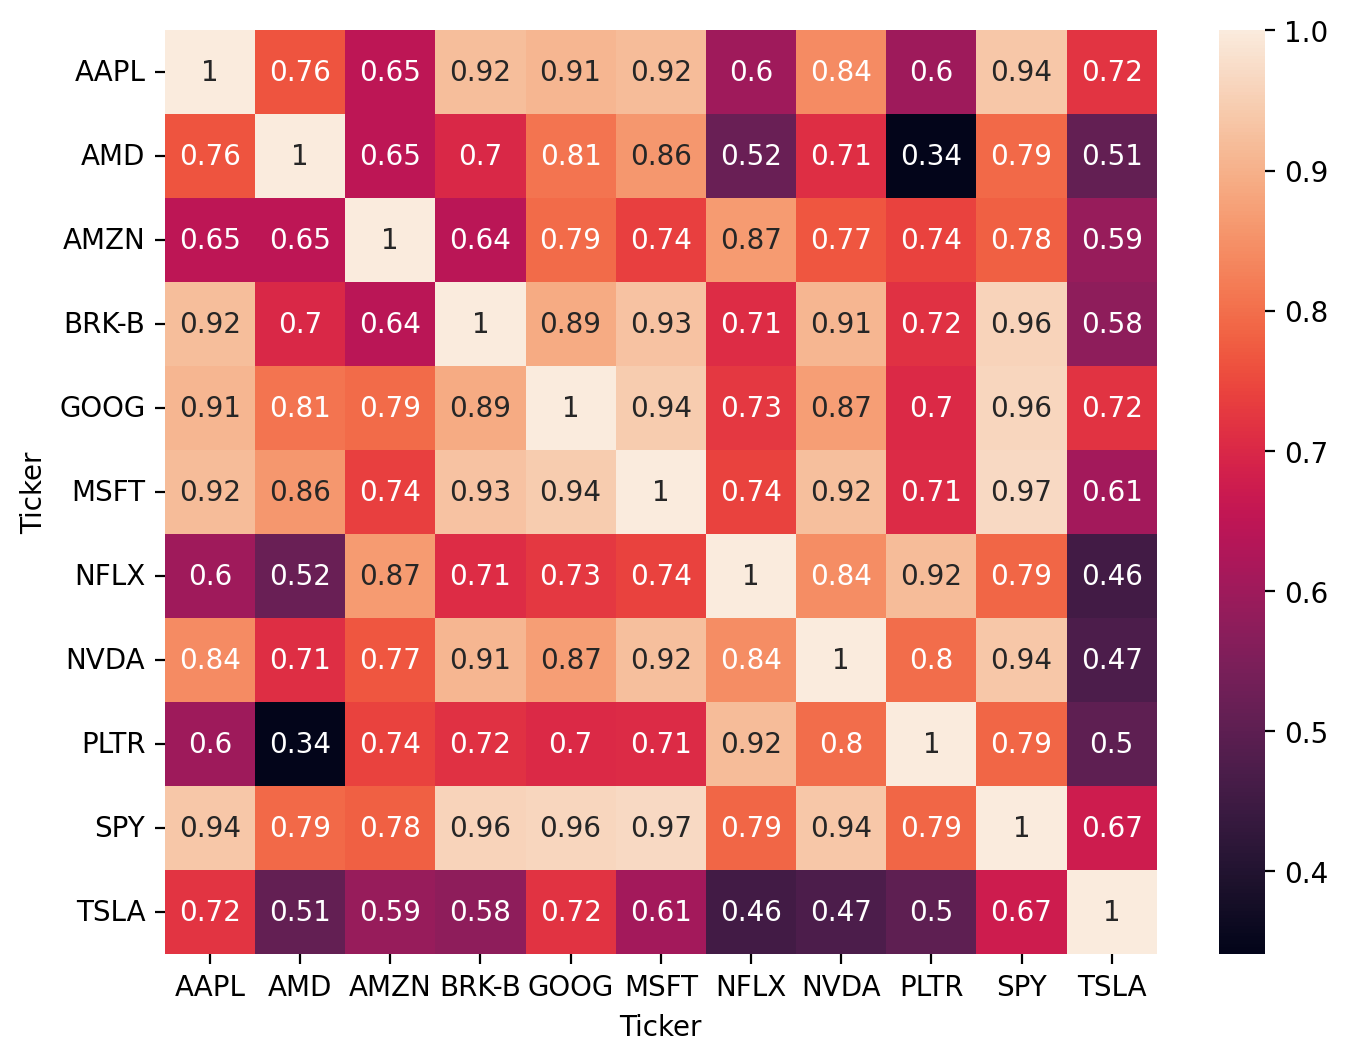

In [9]:
def plot_corr(data):
    corr_mtx = data.corr()
    print(corr_mtx.tail(3))

    plt.figure(figsize=(8, 6), dpi=200)
    sn.heatmap(corr_mtx, annot=True)
    plt.show()

plot_corr(data)

In [86]:
class ResearchPairdTraiding:
    def __init__(self, data: pd.DataFrame, stocks: list[str]):
        stock1, stock2 = stocks
        self.stocks = stocks
        self.data_og = data
        self.data = data[[stock1, stock2]]
        self.stock1, self.stock2 = data[stock1], data[stock2]
        self.ratio = self.stock1 / self.stock2
        self.spread = self.stock1 - self.stock2
        self.df_zscore = None
        print(type(self.spread))
        print(stocks)

    def plot_corr(self, use_original_data=False):
        df = self.data if use_original_data==False else self.data_og
        corr_mtx = df.corr()
        print(corr_mtx.tail(3))

        plt.figure(figsize=(8, 6), dpi=200)
        sn.heatmap(corr_mtx, annot=True)
        plt.show()

    def plot_spread(self):
        plt.figure(figsize=(8, 6), dpi=200)
        plt.plot(self.spread, label=f"spread ({self.stock1} - {self.stock2})")
        plt.axhline(self.spread.mean(), color="red")
        plt.show()

    def plot_ratio(self):
        plt.figure(figsize=(8, 6), dpi=200)
        plt.plot(self.ratio, label=f"spread ({self.stock1} / {self.stock2})")
        plt.axhline(self.ratio.mean(), color="red")
        plt.show()

    def z_score(self, method: str="ratio"):
        self.method = method
        sb = self.ratio if method == "ratio" else self.spread
        self.df_zscore = (sb - sb.mean()) / sb.std()
    
    def plot_z_score(self, quantiles: tuple[float]=(0.05, 0.25, 0.90, 0.95)):
        plt.plot(self.df_zscore, label="Z_score")

        plt.axhline(self.df_zscore.mean(), color="black", linestyle="--", label="Mean")

        for q in quantiles:
            q_val = self.df_zscore.quantile(q)
            color = "red" if q > 0.5 else "green"
            plt.axhline(q_val, color=color, linestyle="--", alpha=0.7, label=f"{int(q*100)}%")

        plt.title(f"Z_score of {self.method} of {self.stocks[0]} to {self.stocks[1]}")
        plt.legend()
        plt.show()
    
    def check_coint(self):
        self.coint = ts.coint(self.stock1, self.stock2)
        coint_stats = self.coint[0]
        p_val = self.coint[1]
        cvt_stats = self.coint[2]
        print(f"p value: {p_val}; \
               \ncointegration: {coint_stats};  \
               \ncritical values test: {cvt_stats};")
        
    def check_adfuller(self):
        stock1_adf = ts.adfuller(self.stock1)
        stock2_adf = ts.adfuller(self.stock2)
        spread_adf = ts.adfuller(self.stock1-self.stock2)
        ratio_adf = ts.adfuller(self.stock1/self.stock2)
        print(f"Augumented Dickey-Fuller test for {self.stocks[0]}: p_val = {stock1_adf[1]}")
        print(f"Augumented Dickey-Fuller test for {self.stocks[1]}: p_val = {stock2_adf[1]}")
        print(f"Augumented Dickey-Fuller test for spread: p_val = {spread_adf[1]}")
        print(f"Augumented Dickey-Fuller test for ratio: p_val = {ratio_adf[1]}")

    def get_params(self):
        if self.df_zscore is None:
            self.df_zscore = self.z_score()
            self.method = "ratio"
        return {
            "spread": self.spread,
            "z_score": self.df_zscore,
            "ratio": self.ratio,
            "method": self.method,
            "data": [self.stock1, self.stock2]
        }



In [87]:
stocks = ["BRK-B", "MSFT"]
pts = ResearchPairdTraiding(data, stocks)
pts.check_coint()
pts.check_adfuller()
pts.z_score(method="ratio")
params = pts.get_params()
print(params)

<class 'pandas.core.series.Series'>
['BRK-B', 'MSFT']
p value: 0.06218684752492287;                
cointegration: -3.248484669311988;                 
critical values test: [-3.90410969 -3.34040314 -3.04741513];
Augumented Dickey-Fuller test for BRK-B: p_val = 0.9437669226649311
Augumented Dickey-Fuller test for MSFT: p_val = 0.901454791297478
Augumented Dickey-Fuller test for spread: p_val = 0.013679466246234681
Augumented Dickey-Fuller test for ratio: p_val = 0.00473776276838151
{'spread': Date
2020-01-02    75.598877
2020-01-03    75.291382
2020-01-06    75.711395
2020-01-07    76.020721
2020-01-08    73.703064
                ...    
2025-09-08    -4.420013
2025-09-09    -5.690002
2025-09-10   -10.290009
2025-09-11    -4.100006
2025-09-12   -16.160004
Length: 1432, dtype: float64, 'z_score': Date
2020-01-02    3.206482
2020-01-03    3.240076
2020-01-06    3.251992
2020-01-07    3.305324
2020-01-08    3.120026
                ...   
2025-09-08   -0.821355
2025-09-09   -0.841702
202

In [102]:
class Backtest:
    def __init__(
            self,  data: pd.DataFrame | list[pd.Series], stocks: list[str], 
            z_score: pd.Series, windows: list[int] = [5, 20, 20],
            ratio:pd.Series | None = None, spread:pd.Series | None=None
        ):
        if spread is not None and ratio is not None:
            raise Exception("Use only one (spread or ratio)")
        self.windows = windows
        self.stocks = stocks
        self.sb = ratio if ratio is not None else spread
        self.method = "ratio" if ratio is not None else "spread"
        self.z_score = z_score 

        if isinstance(data, list) and len(data) == 2:
            self.data = pd.DataFrame({stocks[0]: data[0], stocks[1]: data[1]})
        else:
            self.data = data
        self.prices1 = self.data[stocks[0]]
        self.prices2 = self.data[stocks[1]]
        self.returns1 = self.prices1.pct_change()
        self.returns2 = self.prices2.pct_change()
        self.diff_returns = self.returns1 - self.returns2

        self.sb_mavg_n1 = self.sb.rolling(window=windows[0], center=False).mean()
        self.sb_mavg_n2 = self.sb.rolling(window=windows[1], center=False).mean()
        self.sb_std_n3 = self.sb.rolling(window=windows[2], center=False).std()
        self.z_score__n1_n2 = (self.sb_mavg_n1 - self.sb_mavg_n2) / self.sb_std_n3

    def plot_mean(self):
        plt.figure(figsize=(8, 6), dpi=200)
        plt.plot(self.sb, label='SB')
        plt.plot(self.sb_mavg_n1, label=f'{self.windows[0]}-day MA')
        plt.plot(self.sb_mavg_n2, label=f'{self.windows[1]}-day MA')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(self.method)
        plt.show()

    def plot_z_score(self, quantiles: tuple[float]=(0.05, 0.25, 0.75, 0.95)):
        plt.figure(figsize=(8, 6), dpi=200)
        plt.plot(self.z_score__n1_n2, label="Z_score")

        plt.axhline(self.z_score__n1_n2.mean(), color="black", linestyle="--", label="Mean")

        for q in quantiles:
            q_val = self.z_score__n1_n2.quantile(q)
            color = "red" if q > 0.5 else "green"
            plt.axhline(q_val, color=color, linestyle="--", alpha=0.7, label=f"{int(q*100)}%")

        plt.title(f"Z_score of {self.method} of {self.stocks[0]} to {self.stocks[1]}")
        plt.legend()
        plt.show()

    def backtest(self, initial_cash: float, entry_threshold: float = 2.0, 
                exit_threshold: float = 0.0, position_size: float = None):
        """
        Run the pairs trading backtest.
        
        - Long pair (signal=1): when z < -entry_threshold (buy stock1, short stock2)
        - Short pair (signal=-1): when z > entry_threshold (short stock1, buy stock2)
        - Exit: when z crosses exit_threshold (0 by default)
        - position_size: dollar amount per leg (long V in stock1, short V in stock2 for long pair)
        - Assumes no transaction costs, no slippage, dollar-neutral positions.
        - Uses z_score__n1_n2 for signals (rolling z-score).
        """
        if position_size is None:
            position_size = initial_cash / 2  # Half cash per leg for full exposure
        
        z_scores = self.z_score__n1_n2
        diff_rets = self.diff_returns
        dates = z_scores.index
        
        signals = pd.Series(0.0, index=dates)
        portfolio = pd.Series(0.0, index=dates)
        
        portfolio.iloc[0] = initial_cash
        signals.iloc[0] = 0.0
        current_signal = 0.0
        in_position = False
        
        for i in range(1, len(dates)):
            z = z_scores.iloc[i - 1]
            
            if pd.isna(z):
                # Skip signal update if NaN
                signals.iloc[i] = current_signal
                portfolio.iloc[i] = portfolio.iloc[i - 1]
                continue
            
            # Entry conditions
            if not in_position:
                if z > entry_threshold:
                    current_signal = -1.0  # Short pair
                    in_position = True
                elif z < -entry_threshold:
                    current_signal = 1.0   # Long pair
                    in_position = True
            
            # Exit conditions
            elif in_position:
                if current_signal == 1.0 and z >= exit_threshold:
                    current_signal = 0.0
                    in_position = False
                elif current_signal == -1.0 and z <= exit_threshold:
                    current_signal = 0.0
                    in_position = False
            
            signals.iloc[i] = current_signal
            
            # Daily P&L from the signal held during this period
            daily_pnl = current_signal * position_size * diff_rets.iloc[i]
            portfolio.iloc[i] = portfolio.iloc[i - 1] + (daily_pnl if not pd.isna(daily_pnl) else 0.0)
        
        self.portfolio = portfolio
        self.signals = signals
        
        # Compute stats
        total_return = (portfolio.iloc[-1] / initial_cash - 1) * 100
        num_trades = sum((signals.shift(1) == 0) & (signals != 0))
        
        print(f"Total Return: {total_return:.2f}%")
        print(f"Number of trades: {num_trades}")
        print(f"Final Portfolio Value: {portfolio.iloc[-1]:.2f}")
        
        # Plot results
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)
        
        ax1.plot(portfolio, label='Portfolio Value', color='blue')
        ax1.set_ylabel('Portfolio Value')
        ax1.set_title('Backtest Results')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(signals, label='Signal', color='green', linewidth=1)
        ax2.fill_between(signals.index, signals, 0, where=(signals > 0), alpha=0.3, color='green', label='Long')
        ax2.fill_between(signals.index, signals, 0, where=(signals < 0), alpha=0.3, color='red', label='Short')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.set_ylabel('Signal')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'portfolio': portfolio,
            'signals': signals,
            'total_return': total_return,
            'num_trades': num_trades
        }

Total Return: 16.33%
Number of trades: 67
Final Portfolio Value: 1163.33


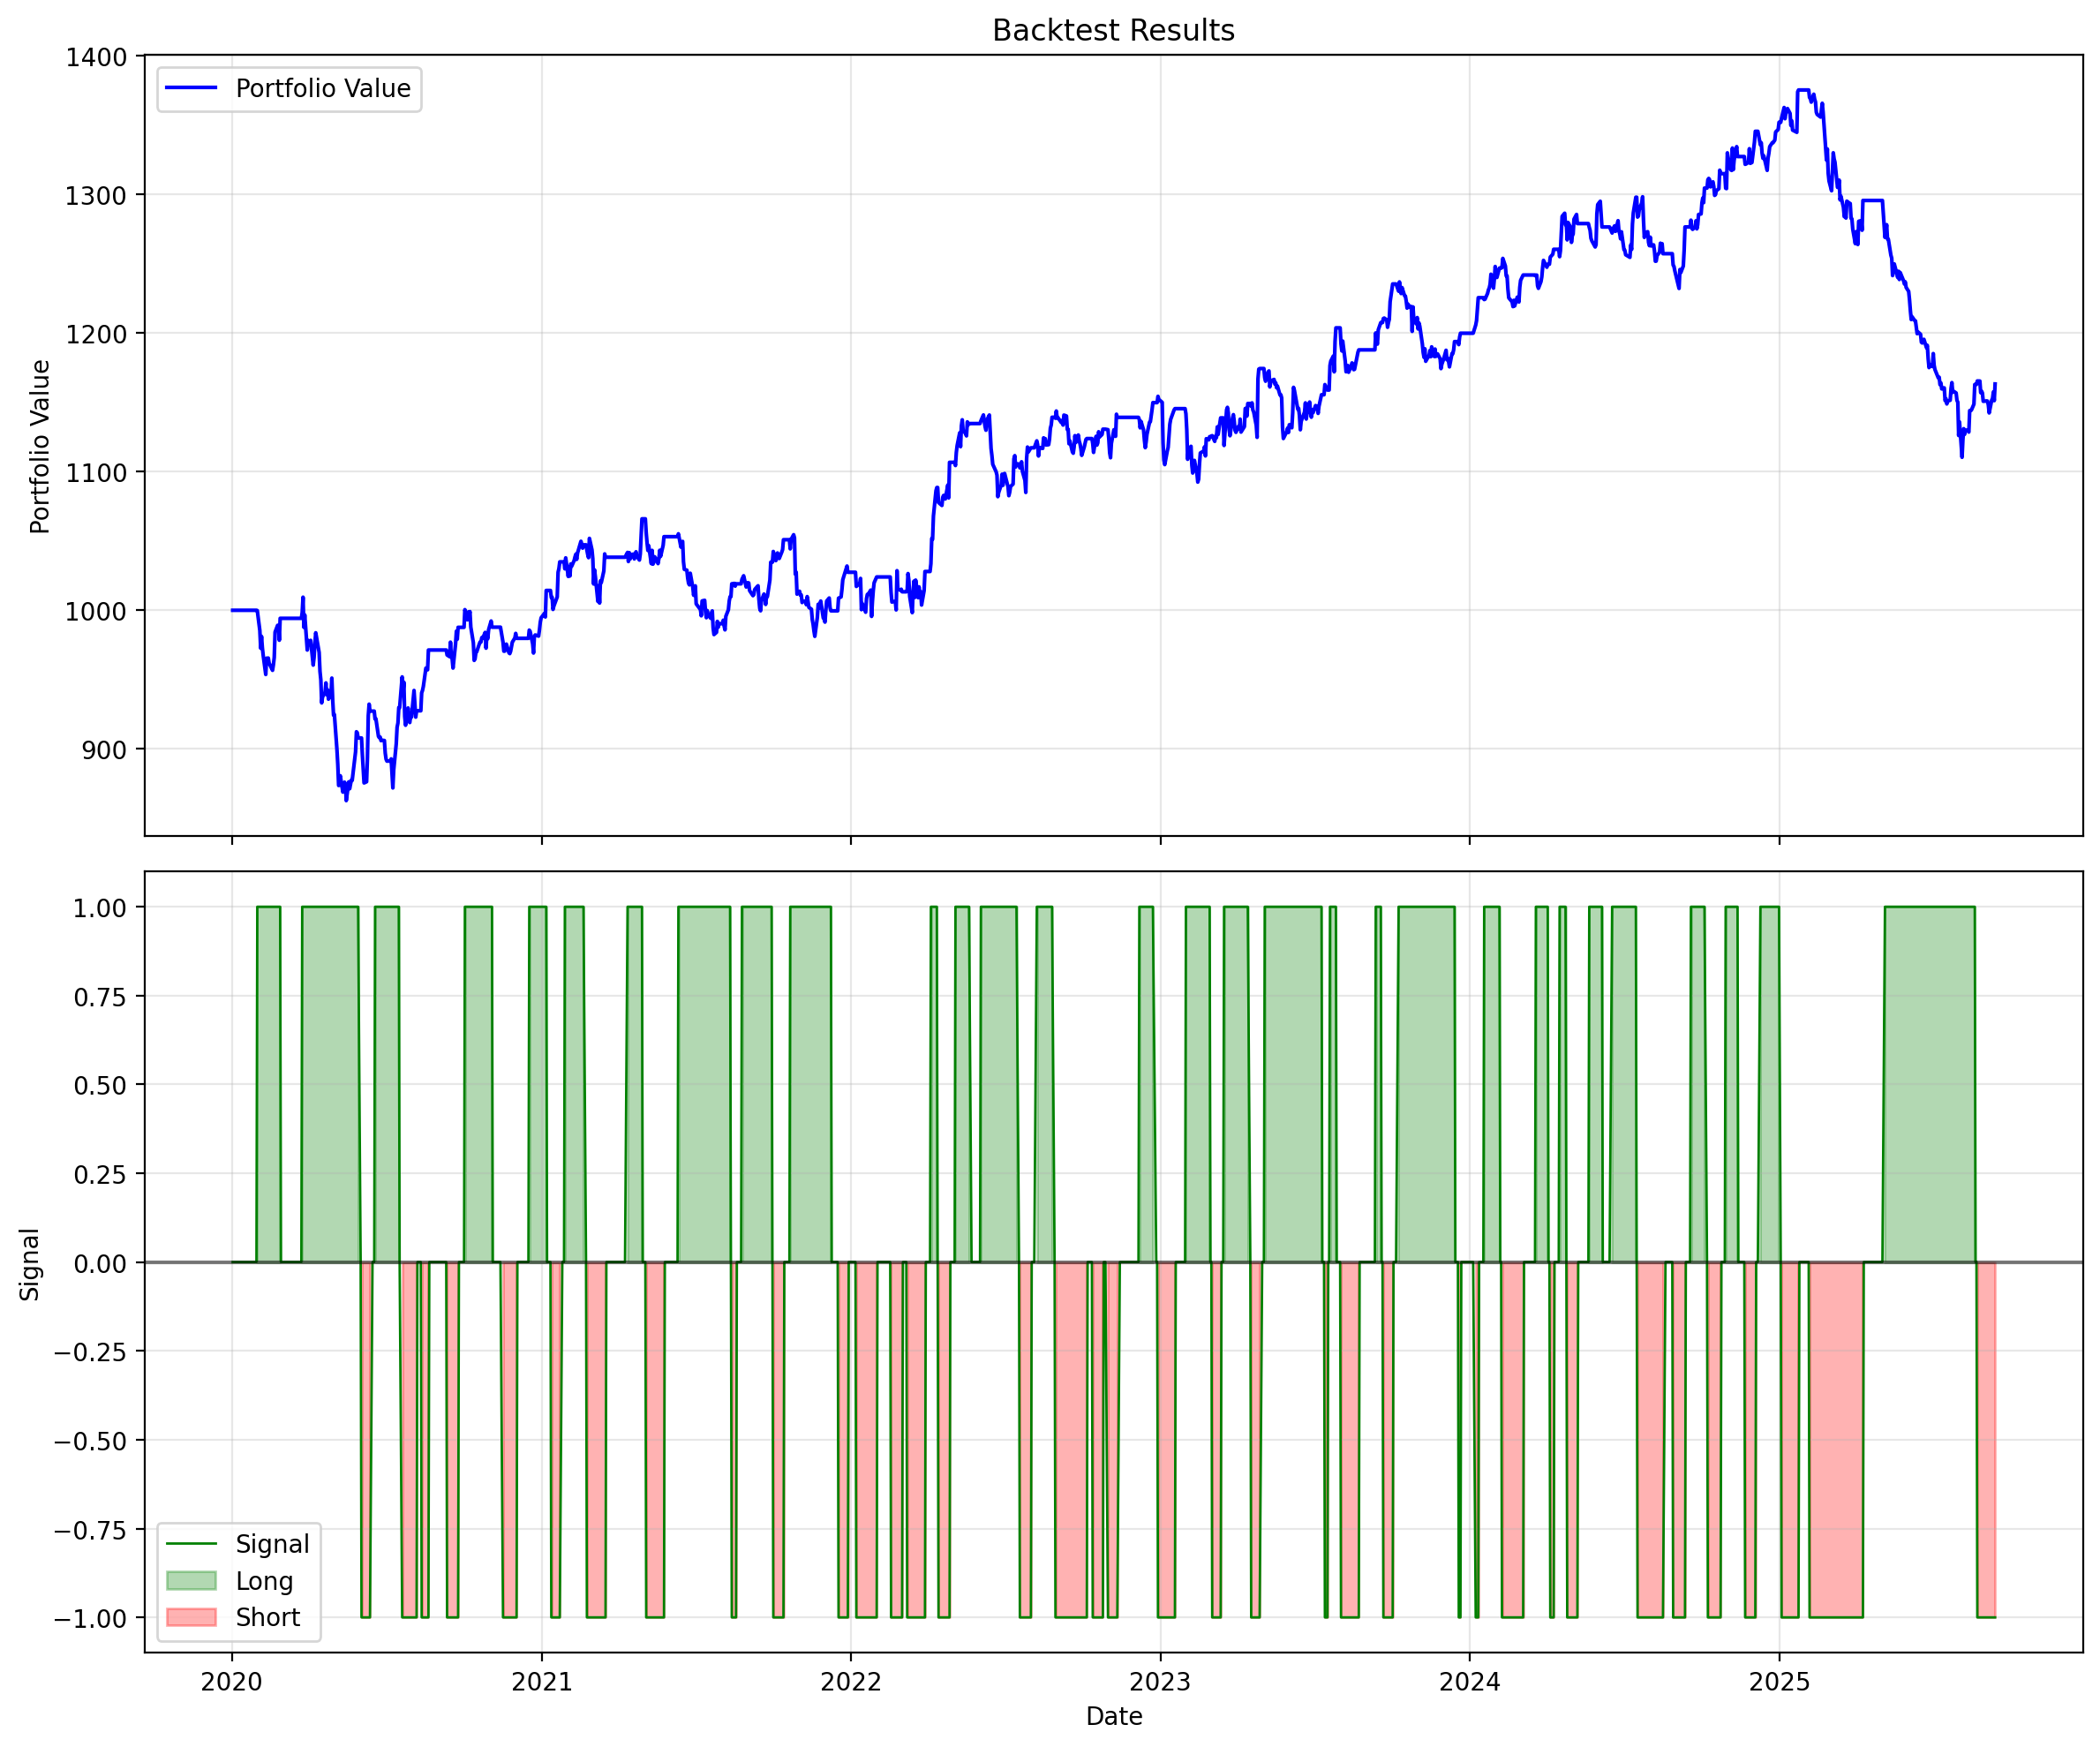

{'portfolio': Date
2020-01-02    1000.000000
2020-01-03    1000.000000
2020-01-06    1000.000000
2020-01-07    1000.000000
2020-01-08    1000.000000
                 ...     
2025-09-08    1151.665371
2025-09-09    1152.949471
2025-09-10    1157.594736
2025-09-11    1151.266010
2025-09-12    1163.327798
Length: 1432, dtype: float64, 'signals': Date
2020-01-02    0.0
2020-01-03    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
             ... 
2025-09-08   -1.0
2025-09-09   -1.0
2025-09-10   -1.0
2025-09-11   -1.0
2025-09-12   -1.0
Length: 1432, dtype: float64, 'total_return': 16.332779812233845, 'num_trades': 67}


In [120]:
params = pts.get_params() 
bt = Backtest(
    data=params["data"],
    stocks=stocks,
    z_score=params["z_score"],
    ratio=params["ratio"]
)
results = bt.backtest(initial_cash=1000, entry_threshold=1, exit_threshold=0.5)
print(results)